## Problem Set 3

### Joseph Denby

In [227]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

In [2]:
incomes = np.loadtxt("../../ProblemSets/PS2/incomes.txt")

#### Problem 1

a). Plot a histogram of percentages of the `income.txt` data with 30 bins. Make sure that the bins are weighted using the `normed=True` option. Make sure your plot has correct $x$-axis and $y$-axis labels as well as a plot title.

<IPython.core.display.Javascript object>


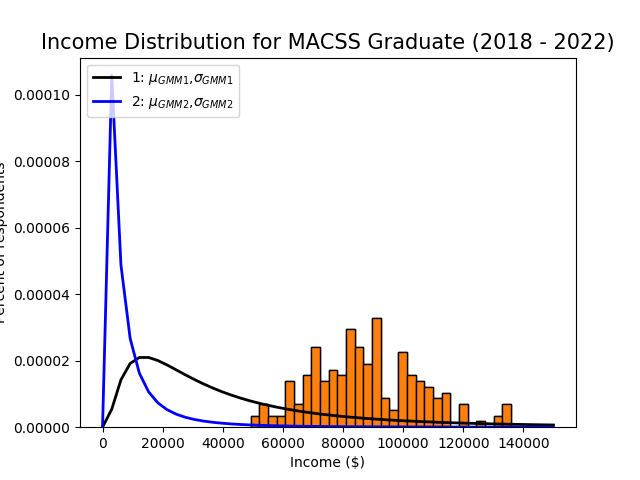

Text(0,0.5,'Percent of respondents')

In [223]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Income Distribution for MACSS Graduate (2018 - 2022)', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of respondents')


b). Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix $\hat{\boldsymbol{W}}$. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.

In [142]:
def lognormpdf(x, mu, sigma):
    pdfvals = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-1 * (((np.log(x)-mu)**2)/(2*sigma**2)))
    return pdfvals

In [143]:
def data_moments(xvals):
    data_mean = xvals.mean()
    data_std = xvals.std()
    
    return data_mean, data_std

In [144]:
def model_moments(mu, sigma):
    xfx = lambda x: x * lognormpdf(x, mu, sigma)
    (model_mean, m_m_err) = intgr.quad(xfx, .01, np.inf)
    x2fx = lambda x: ((x - model_mean)** 2) * lognormpdf(x, mu, sigma)
    (model_var, v_m_err) = intgr.quad(x2fx, .01, np.inf)
    model_std = np.sqrt(model_var)
    
    return model_mean, model_std

In [145]:
def error_vec(xvals, mu, sigma, simple):
    data_mean, data_std = data_moments(xvals)
    data_moms = np.array([[data_mean], [data_std]])
    model_mean, model_std = model_moments(mu, sigma)
    model_moms = np.array([[model_mean], [model_std]])
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

In [146]:
def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err_vec = error_vec(xvals, mu, sigma, simple = True)
    crit_val = np.dot(np.dot(err_vec.T, W), err_vec)
    
    return crit_val
    

In [216]:
mu_init = 8
sig_init = .7
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion, params_init, args= gmm_args,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print("Mu estimate: ", mu_GMM1, "\nSigma estimate: ", sig_GMM1, "\nCriterion value: ",criterion((mu_GMM1, sig_GMM1), incomes, W_hat))

/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


Mu estimate:  10.354393886017968 
Sigma estimate:  0.9097929738174386 
Criterion value:  [[2.8278238e+09]]


In [148]:
data_mean, data_std = data_moments(incomes)
print("Data mean: ", data_mean, "\nData sigma: ", data_std)
model_mean, model_std = model_moments(mu_GMM1, sig_GMM1)
print("Model mean: ", model_mean, "\nModel sigma: ", model_std)
err_vec = error_vec(incomes, mu_GMM1, sig_GMM1, simple = True)
err_vec

Data mean:  87588.93076851241 
Data sigma:  18035.906827092327
Model mean:  47326.12350343659 
Model sigma:  52773.92856536445


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


array([[-40262.80726508],
       [ 34738.02173827]])

In [224]:
# Plot the histogram of the data
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Income Distribution for MACSS Graduate (2018 - 2022)', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of respondents')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.01, 150000)
plt.plot(dist_pts, lognormpdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

In [156]:
print(err1)
print(err_vec)


[[-0.45967917]
 [ 1.92604797]]
[[-40262.80726508]
 [ 34738.02173827]]


c). Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix $\hat{\boldsymbol{\Omega}}_{2step}$, which you then use to get the two-step estimator for the optimal weighting matrix $\hat{\boldsymbol{W}}_{2step}$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.

In [167]:
def criterion_optimal(params, *args):
    mu, sigma = params
    xvals, W = args
    err_vec = error_vec(xvals, mu, sigma, simple = False)
    crit_val = np.dot(np.dot(err_vec.T, W), err_vec)
    
    return crit_val
    

In [168]:
err1 = error_vec(incomes, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print("VCV Matrix Estimate:\n", VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print("Optimal Weighting Matrix:\n ", W_hat2)

VCV Matrix Estimate:
 [[ 0.00105652 -0.00442682]
 [-0.00442682  0.0185483 ]]
Optimal Weighting Matrix:
  [[  2.74886593 -11.5177018 ]
 [-11.5177018   48.25897601]]


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [169]:
mu_init = 8
sig_init = .7
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, W_hat2)
results = opt.minimize(criterion_optimal, params_init, args= gmm_args,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print("Mu estimate: ", mu_GMM2, "\nSigma estimate: ", sig_GMM2, "\nCriterion value: ",criterion((mu_GMM2, sig_GMM2), incomes, W_hat2))

Mu estimate:  8.197480143577419 
Sigma estimate:  1.2187217040702778 
Criterion value:  [[1.10814863e+10]]


In [170]:
data_mean, data_std = data_moments(incomes)
print("Data mean: ", data_mean, "\nData sigma: ", data_std)
model1_mean, model1_std = model_moments(mu_GMM1, sig_GMM1)
print("Model 1 mean: ", model1_mean, "\nModel 1 sigma: ", model1_std)
model2_mean, model2_std = model_moments(mu_GMM2, sig_GMM2)
print("Optimal weighting model mean: ", model2_mean, "\nOptimal weighting model sigma: ", model2_std)


Data mean:  87588.93076851241 
Data sigma:  18035.906827092327
Model 1 mean:  47326.12350343659 
Model 1 sigma:  52773.92856536445
Optimal weighting model mean:  7632.123841278394 
Optimal weighting model sigma:  14106.455183080885


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [225]:
dist_pts = np.linspace(0.01, 150000)
plt.plot(dist_pts, lognormpdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=2, color='b', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

d). Now estimate the lognormal PDF to fit the data by GMM using different moments. Use percent of individuals who earn less than \$75,000, percent of individuals who earn between \$75,000 and \$100,000, and percent of individuals who earn more than \$100,000 as your three moments. Use the identity matrix as your estimator for the optimal weighting matrix. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

First, the functions needed for estimating using the new moments.

In [164]:
def pct_data_moments(xvals):
    total = xvals.shape[0]
    pct1_data = xvals[xvals < 75000].shape[0]/total
    pct2_data = xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] / total
    pct3_data = xvals[xvals >= 100000].shape[0] / total
    
    return pct1_data, pct2_data, pct3_data

In [178]:
pct_data_moments(incomes)

(0.265, 0.475, 0.26)

In [183]:
def pct_mod_moments(mu, sigma):
    xfx = lambda x: lognormpdf(x, mu, sigma)
    (pct1_model, pct1_err) = intgr.quad(xfx, 0, 75000)
    (pct2_model, pct2_err) = intgr.quad(xfx, 75000, 100000)
    (pct3_model, pct3_err) = intgr.quad(xfx, 100000, np.inf)
    
    return pct1_model, pct2_model, pct3_model

In [188]:
pct_mod_moments(11, .18)

(0.8945969922146072, 0.10321419875134624, 0.0021888090340504173)

In [189]:
def err_vec2(xvals, mu, sigma, simple):
    pct1_data, pct2_data, pct3_data = pct_data_moments(xvals)
    data_moms = np.array([[pct1_data], [pct2_data], [pct3_data]])
    
    pct1_model, pct2_model, pct3_model = pct_mod_moments(mu, sigma)
    model_moms = np.array([[pct1_model], [pct2_model], [pct3_model]])
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = 100 * ((model_moms - data_moms) / data_moms)
    
    return err_vec

In [203]:
def criterion2(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec2(xvals, mu, sigma, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [204]:
criterion2((11,.18),incomes, W_hat)

array([[0.60108366]])

Now, we can try to estimate the model parameters.

In [215]:
mu_init = 8
sig_init = .7
params_init = np.array([mu_init, sig_init])
W_hat3 = np.eye(3)
gmm_args = (incomes, W_hat3)
results = opt.minimize(criterion2, params_init, args= (gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results.x
print("Pct Mu estimate: ", mu_GMM3, "\nPct Sigma estimate: ", sig_GMM3, "\nCriterion value: ",criterion2((mu_GMM3, sig_GMM3), incomes, W_hat3))

/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 


Pct Mu estimate:  9.286567332345987 
Pct Sigma estimate:  6.599728633796923 
Criterion value:  [[0.3335108]]


In [208]:
pct1_data, pct2_data, pct3_data = pct_data_moments(incomes)
pct1_model, pct2_model, pct3_model = pct_mod_moments(mu_GMM3, sig_GMM3)
print("From data:\n")
print("% less than $75000: ", pct1_data, "\n% between $75000 and $100000: ", pct2_data, "\n% above $100000: ", pct3_data)
print("\nFrom model:\n")
print("% less than $75000: ", pct1_model, "\n% between $75000 and $100000: ", pct2_model, "\n% above $100000: ", pct3_model)

From data:

% less than $75000:  0.265 
% between $75000 and $100000:  0.475 
% above $100000:  0.26

From model:

% less than $75000:  0.6155258498853857 
% between $75000 and $100000:  0.01654415731869369 
% above $100000:  0.28146312898969594


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [213]:
dist_pts = np.linspace(0.01, 150000)
plt.plot(dist_pts, lognormpdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='r', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

In [218]:
print("Mu estimate: ", mu_GMM1, "\nSigma estimate: ", sig_GMM1, "\nCriterion value: ",criterion((mu_GMM1, sig_GMM1), incomes, W_hat))
print("Opt mu estimate: ", mu_GMM2, "\nOpt sigma estimate: ", sig_GMM2, "\nCriterion value: ",criterion((mu_GMM2, sig_GMM2), incomes, W_hat2))
print("Pct Mu estimate: ", mu_GMM3, "\nPct Sigma estimate: ", sig_GMM3, "\nCriterion value: ",criterion2((mu_GMM3, sig_GMM3), incomes, W_hat3))


Mu estimate:  10.354393886017968 
Sigma estimate:  0.9097929738174386 
Criterion value:  [[2.8278238e+09]]
Opt mu estimate:  8.197480143577419 
Opt sigma estimate:  1.2187217040702778 
Criterion value:  [[1.10814863e+10]]
Pct Mu estimate:  9.286567332345987 
Pct Sigma estimate:  6.599728633796923 
Criterion value:  [[0.3335108]]


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


e). Perform the two-step GMM estimator by using your estimates from part (d) with three moments to generate an estimator for the variance covariance matrix $\hat{\boldsymbol{\Omega}}_2step$, which you then use to get the two-step estimator for the optimal weighting matrix $\hat{\boldsymbol{W}}_2step$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (d). Report and compare your three data moments against your three model moments at the estimated parameter values.

In [219]:
err2 = err_vec2(incomes, mu_GMM3, sig_GMM3, False)
VCV3 = np.dot(err2, err2.T) / incomes.shape[0]
print("VCV Matrix Estimate:\n", VCV3)
W_hat4 = lin.pinv(VCV3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print("Optimal Weighting Matrix:\n ", W_hat4)

VCV Matrix Estimate:
 [[ 87.48193054 -63.83341565   5.45963827]
 [-63.83341565  46.57767528  -3.98376392]
 [  5.45963827  -3.98376392   0.34072922]]
Optimal Weighting Matrix:
  [[ 4.84303554e-03 -3.53384406e-03  3.02247812e-04]
 [-3.53384406e-03  2.57855920e-03 -2.20542804e-04]
 [ 3.02247812e-04 -2.20542804e-04  1.88629093e-05]]


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [220]:
mu_init = 8
sig_init = .7
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, W_hat4)
results = opt.minimize(criterion2, params_init, args= (gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results.x
print("Opt Pct Mu estimate: ", mu_GMM4, "\nOpt Pct Sigma estimate: ", sig_GMM4, "\nCriterion value: ",criterion2((mu_GMM4, sig_GMM4), incomes, W_hat4))

Opt Pct Mu estimate:  8.0 
Opt Pct Sigma estimate:  0.7 
Criterion value:  [[0.00549687]]


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [221]:
dist_pts = np.linspace(0.01, 150000)
plt.plot(dist_pts, lognormpdf(dist_pts, mu_GMM4, sig_GMM4),
         linewidth=2, color='y', label='4: $\mu_{GMM4}$,$\sigma_{GMM4}$')
plt.legend(loc='upper left')

In [222]:
pct1_data, pct2_data, pct3_data = pct_data_moments(incomes)
pct1_model, pct2_model, pct3_model = pct_mod_moments(mu_GMM4, sig_GMM4)
print("From data:\n")
print("% less than $75000: ", pct1_data, "\n% between $75000 and $100000: ", pct2_data, "\n% above $100000: ", pct3_data)
print("\nFrom model:\n")
print("% less than $75000: ", pct1_model, "\n% between $75000 and $100000: ", pct2_model, "\n% above $100000: ", pct3_model)

From data:

% less than $75000:  0.265 
% between $75000 and $100000:  0.475 
% above $100000:  0.26

From model:

% less than $75000:  0.999997962211506 
% between $75000 and $100000:  1.7773585275231743e-06 
% above $100000:  1.6097003787277763e-09


/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


f). Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

Based on the parameter estimates for the four models (as well as the eyeball test), it seems as though the latter two models failed completely, either due to a poor choice in moments or, more likely, a mechanical error on my part. As such, the first two models are better choices. Neither of those two are particularly appealing either, but, if forced to choose, I would opt for the first, only because its distribution seems a better match visually to the data distribution.

#### Problem 2

In [228]:
sickdf = pd.read_csv("../../ProblemSets/PS2/sick.txt")
sick = sickdf['sick']
age = sickdf['age']
children = sickdf['children']
temp = sickdf['avgtemp_winter']

In [239]:
def model_moments(variables, params):
    sick, age, children, temp = variables
    b0, b1, b2, b3 = params
    model_moms = (b0 + b1*age + b2*children + b3*temp)
    
    return model_moms

In [258]:
def sick_error_vec(variables, params):
    sick, age, children, temp = variables
    model_moms = model_moments(variables, params)
    sick_error_vec = sick - model_moms
    
    return sick_error_vec

In [259]:
def sick_criterion(params, *args):
    b0, b1, b2, b3 = params
    sick, age, children, temp, W = args
    variables = (sick, age, children, temp)
    err_vec = sick_error_vec(variables, params)
    crit_val = np.dot(np.dot(err_vec.T, W), err_vec)
    
    return crit_val 

In [257]:
b0_init = 3
b1_init = 2
b2_init = 4
b3_init = 1
params_init = np.array([b0_init, b1_init, b2_init, b3_init])
W_sick = np.eye(200)
gmm_args = (sick, age, children, temp, W_sick)
results = opt.minimize(sick_criterion, params_init, args= (gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (None, None),(None, None), (None, None)))
b0_GMM, b1_GMM, b2_GMM, b3_GMM = results.x
print('Optimal b0 =', b0_GMM, "\nOptimal b1 = ", b1_GMM, "\nOptimal b2 = ", b2_GMM, "\nOptimal b3 = ", b3_GMM)
print('Optimal criterion = ', sick_criterion((b0_GMM, b1_GMM, b2_GMM, b3_GMM), sick, age, children, temp, W_sick))

Optimal b0 = 0.25164509437052196 
Optimal b1 =  0.01293347440605325 
Optimal b2 =  0.4005009186979826 
Optimal b3 =  -0.009991711364417786
Optimal criterion =  0.0018212898084662768
